In [1]:
import numpy as np                      
import pandas as pd                     
import matplotlib.pyplot as plt         


from sklearn.pipeline import Pipeline                          
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer                   


from imblearn.combine import SMOTEENN                           
from imblearn.pipeline import Pipeline as ImbPipeline           

from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV



from sklearn.feature_selection import SelectFromModel           


from sklearn.ensemble import RandomForestClassifier     

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             roc_curve, ConfusionMatrixDisplay)

In [2]:
import pandas as pd
df=pd.read_csv(r"C:\Users\dell\Downloads\telco.csv")

In [3]:
print("Columns:", df.columns.tolist())        # List column names
print("Shape:", df.shape)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Shape: (7043, 21)


In [4]:
df=pd.read_csv(r"C:\Users\dell\Downloads\telco.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Numerical summary
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Categorical summary
df.describe(include=['O'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [7]:

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Count missing values per column
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# Check class balance for churn
counts = df['Churn'].value_counts()
percentages = df['Churn'].value_counts(normalize=True) * 100

imbalance_table = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages.round(2)
})
imbalance_table

,Count,Percentage (%)
Churn,,
No,5174,73.46
Yes,1869,26.54


In [9]:
df = df.dropna(subset=['TotalCharges'])

# Confirm no more missing values
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
y = df['Churn'].map({'No': 0, 'Yes': 1})  
X = df.drop(['customerID', 'Churn'], axis=1)  

In [11]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [12]:

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(
        drop='first',
        sparse_output=False,
        handle_unknown='ignore'
    ))
])

#  - Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [13]:
smote_enn = SMOTEENN(random_state=42)

# Full pipeline: preprocessing → resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', smote_enn)
])

# Apply transformations
X_resampled, y_resampled = pipeline.fit_resample(X, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (5199, 30) (5199,)
Testing set shape: (1300, 30) (1300,)


In [15]:
rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [16]:
y_pred  = rf.predict(X_test)              
y_proba = rf.predict_proba(X_test)[:, 1]  

# Print key metrics
print("Default Random Forest Performance")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba):.4f}\n")
print(classification_report(y_test, y_pred))

Default Random Forest Performance
F1-score : 0.9647
AUC-ROC  : 0.9920

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       558
           1       0.97      0.96      0.96       742

    accuracy                           0.96      1300
   macro avg       0.96      0.96      0.96      1300
weighted avg       0.96      0.96      0.96      1300



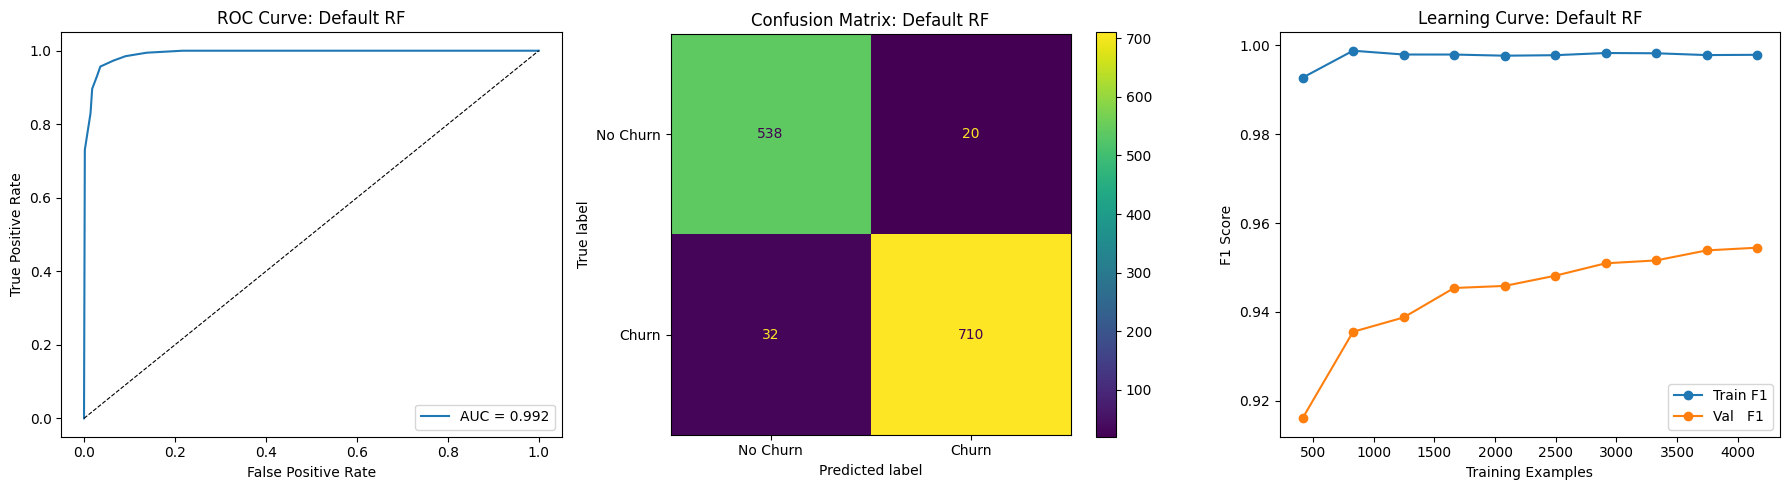

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- a) Learning Curve Data (F1) ---
train_sizes, train_scores, val_scores = learning_curve(
    rf,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

# --- b) ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=0.8) 
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve: Default RF")
axes[0].legend()

# --- c) Confusion Matrix ---
ConfusionMatrixDisplay.from_estimator(
    rf,
    X_test,
    y_test,
    display_labels=['No Churn','Churn'],
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix: Default RF")

# --- d) Learning Curve (F1) ---
axes[2].plot(train_sizes, train_mean, marker='o', label='Train F1')
axes[2].plot(train_sizes, val_mean,   marker='o', label='Val   F1')
axes[2].set_xlabel("Training Examples")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("Learning Curve: Default RF")
axes[2].legend()

# Adjust layout and display all plots
plt.tight_layout()
plt.show()

In [18]:
param_dist = {
    'n_estimators': [100, 200, 500],        
    'max_depth': [None, 10, 20, 30],        
    'min_samples_split': [2, 5, 10],        
    'min_samples_leaf': [1, 2, 4],          
    'max_features': ['sqrt'],               
    'bootstrap': [False]                    
}

# Setup RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=rf,                          
    param_distributions=param_dist,
    n_iter=20,                              
    scoring='f1',                           
    cv=5,                                   
    return_train_score=True,
    random_state=42,
    n_jobs=-1,                              
    verbose=1
)

# Fit the search on the training data
rs.fit(X_train, y_train)

# Extract the best estimator and its parameters
best_rf = rs.best_estimator_
print("Best hyperparameters:", rs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [19]:
y_pred_tuned  = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

# Print performance metrics
print("Tuned Random Forest Performance")
print(f"F1-score : {f1_score(y_test, y_pred_tuned):.4f}")
print(f"AUC-ROC  : {roc_auc_score(y_test, y_proba_tuned):.4f}\n")
print(classification_report(y_test, y_pred_tuned))

Tuned Random Forest Performance
F1-score : 0.9712
AUC-ROC  : 0.9949

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       558
           1       0.97      0.98      0.97       742

    accuracy                           0.97      1300
   macro avg       0.97      0.97      0.97      1300
weighted avg       0.97      0.97      0.97      1300



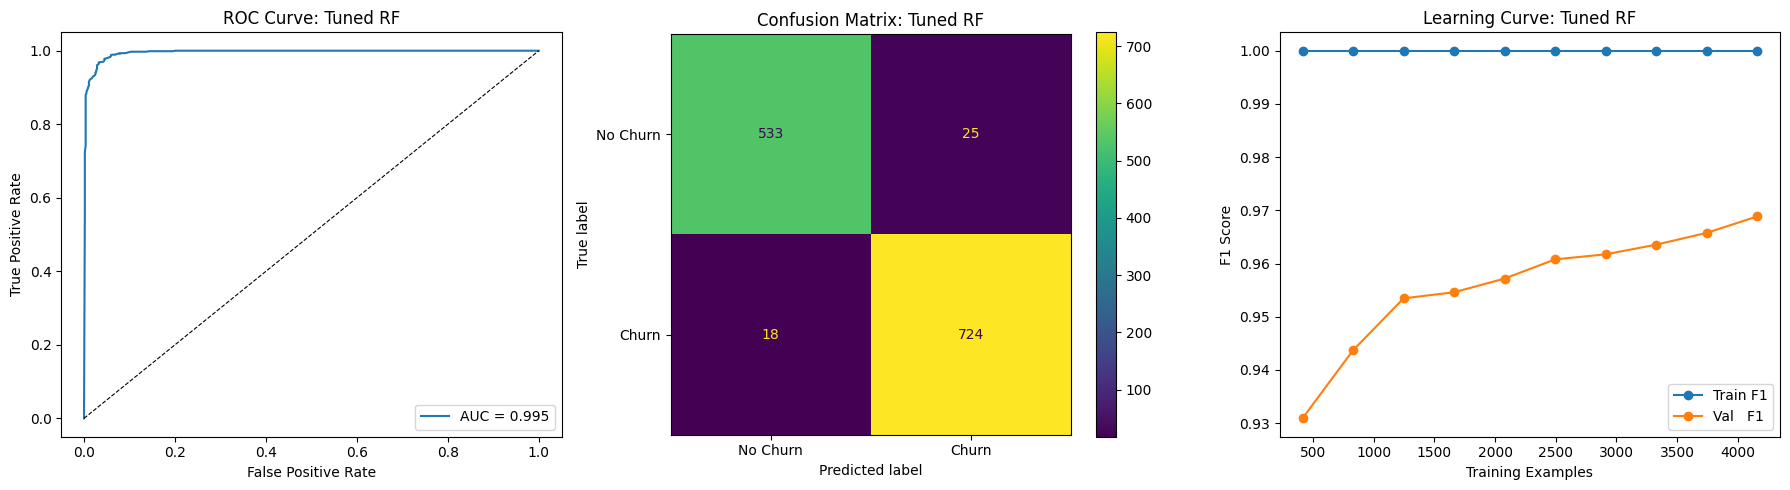

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  a) Learning curve data (F1)
train_sizes_t, train_scores_t, val_scores_t = learning_curve(
    best_rf,
    X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
train_mean_t = train_scores_t.mean(axis=1)
val_mean_t   = val_scores_t.mean(axis=1)

#  b) ROC Curve
fpr_t, tpr_t, _ = roc_curve(y_test, y_proba_tuned)
axes[0].plot(fpr_t, tpr_t, label=f"AUC = {roc_auc_score(y_test, y_proba_tuned):.3f}")
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=0.8)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve: Tuned RF")
axes[0].legend()

#  c) Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=['No Churn', 'Churn'],
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix: Tuned RF")

#  d) Learning Curve (F1)
axes[2].plot(train_sizes_t, train_mean_t, marker='o', label='Train F1')
axes[2].plot(train_sizes_t, val_mean_t,   marker='o', label='Val   F1')
axes[2].set_xlabel("Training Examples")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("Learning Curve: Tuned RF")
axes[2].legend()

plt.tight_layout()
plt.show()

In [21]:
# Datasets
datasets = {
    'Train': (X_train, y_train),
    'Test':  (X_test,  y_test),
}

# Models
models = {
    'Default RF': rf,
    'Tuned RF  ':   best_rf,
}

# Collect metrics
records = []
for ds_name, (X_ds, y_ds) in datasets.items():
    for name, model in models.items():
        y_pred = model.predict(X_ds)
        y_proba = model.predict_proba(X_ds)[:, 1]
        records.append({
            'Model':    name,
            'Dataset':  ds_name,'F1-score': f1_score(y_ds, y_pred),
            'AUC-ROC ':  roc_auc_score(y_ds, y_proba),
        })

df = pd.DataFrame(records)
# Pivot so metrics for Train/Test are side by side
pivot = df.pivot(index='Model', columns='Dataset', values=['F1-score','AUC-ROC '])
# Compute Train minus Test gaps
gaps = pivot.xs('Train', axis=1, level=1) - pivot.xs('Test', axis=1, level=1)
gaps.columns = [c + ' gap (Train–Test)' for c in gaps.columns]

# Combine into one summary table
summary = pd.concat([pivot, gaps], axis=1)
summary


,"(F1-score, Test)","(F1-score, Train)","(AUC-ROC , Test)","(AUC-ROC , Train)",F1-score gap (Train–Test),AUC-ROC gap (Train–Test)
Model,,,,,,
Default RF,0.964674,0.998651,0.992038,0.999987,0.033977,0.007949
Tuned RF,0.971160,1.000000,0.994911,1.000000,0.028840,0.005089


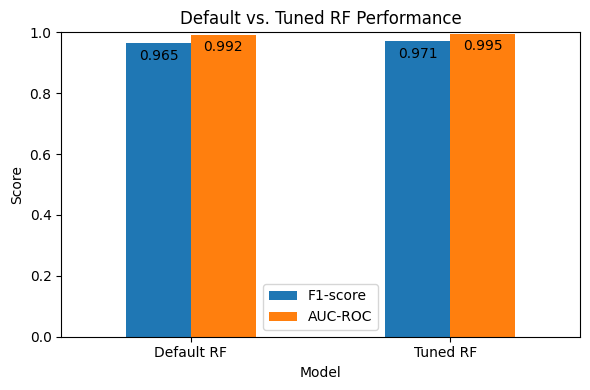

In [22]:
# Plot comparison
test_scores = summary[[('F1-score','Test'), ('AUC-ROC ','Test')]].copy()
test_scores.columns = ['F1-score','AUC-ROC']

ax = test_scores.plot(
kind='bar',
    ylim=(0, 1),
    rot=0,
    figsize=(6, 4),
    title="Default vs. Tuned RF Performance"
)
ax.set_ylabel("Score")

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=-14)

plt.tight_layout()
plt.show()

In [23]:
# Overfitting Check
print("Overfitting Checks")
for model in summary.index:
    for metric in ['F1-score', 'AUC-ROC ']:
        gap = summary.loc[model, f'{metric} gap (Train–Test)']
        status = "OVERFITTING" if gap > 0.05 else "No overfitting"
        print(f"{model} — {metric}: gap={gap:.3f} -> {status}")

Overfitting Checks
Default RF — F1-score: gap=0.034 -> No overfitting
Default RF — AUC-ROC : gap=0.008 -> No overfitting
Tuned RF   — F1-score: gap=0.029 -> No overfitting
Tuned RF   — AUC-ROC : gap=0.005 -> No overfitting


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv(r"C:\Users\dell\Downloads\telco.csv")

# Clean and preprocess the data
df = df[df['TotalCharges'] != ' ']  
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.drop('customerID', axis=1, inplace=True)  
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})  

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Preview of test data
print(X_test.head())


      SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
2481              1      61           25.00       1501.75         True   
6784              0      19           24.70        465.85        False   
6125              0      13          102.25       1359.00         True   
3052              0      37           55.05       2030.75         True   
4099              0       6           29.45        161.45        False   

      Partner_Yes  Dependents_Yes  PhoneService_Yes  \
2481         True           False              True   
6784        False           False              True   
6125         True           False              True   
3052         True           False              True   
4099        False           False             False   

      MultipleLines_No phone service  MultipleLines_Yes  ...  \
2481                           False               True  ...   
6784                           False               True  ...   
6125                           F